In [ ]:
#%pip install numpy pandas matplotlib seaborn scikit-learn
%pip install nbconvert
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from matplotlib import cm
from sklearn import tree
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neural_network import MLPClassifier

In [4]:
# Load the dataset
trainset = pd.read_csv('adult_train.csv', header=0)
testset = pd.read_csv('adult_test.csv', header=0)

In [5]:
# Transform '?' to NaN
trainset = trainset.replace(' ?', np.nan)
testset = testset.replace(' ?', np.nan)

# Check whether there are missing values
print(trainset.isnull().sum())
print(testset.isnull().sum())

age                  0
work-class        1836
fnlwgt               0
education            0
edu-num              0
marital              0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital loss         0
hours-per-week       0
native             583
income               0
dtype: int64
age                 0
work-class        963
fnlwgt              0
education           0
edu-num             0
marital             0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital loss        0
hours-per-week      0
native            274
income              0
dtype: int64


In [6]:
# Specify which columns are numeric vs. categorical
numeric_cols = [
    'age', 'fnlwgt', 'edu-num',
    'capital-gain','capital loss',
    'hours-per-week'
]
categorical_cols = [
    'work-class','education','marital',
    'occupation','relationship','race',
    'sex','native'
]

# Target variable transformation to make it standard
trainset['income'] = trainset['income'].replace({' <=50K': '<50,000', ' >50K': '>50,000'})
testset['income'] = testset['income'].replace({' <=50K.': '<50,000', ' >50K.': '>50,000'})

# Split into features and target
X_train = trainset.drop(columns=['income'])
y_train = trainset['income']
X_test = testset.drop(columns=['income'])
y_test = testset['income']


# Check the shape of the data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Check the distribution of the target variable
pd.set_option('display.html.use_mathjax', False)
print(y_train.value_counts())
print(y_test.value_counts())

(32561, 14)
(16281, 14)
(32561,)
(16281,)
income
<50,000    24720
>50,000     7841
Name: count, dtype: int64
income
<50,000    12435
>50,000     3846
Name: count, dtype: int64


In [7]:
# Build preprocessor to deal with missing values
tree_preprocessor = ColumnTransformer([
    # scale numerics
    ('num', StandardScaler(), numeric_cols),
    # constant‐impute + ordinal‐encode cats
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('ord',     OrdinalEncoder(handle_unknown='use_encoded_value',
                                   unknown_value=-1))
    ]), categorical_cols),
])

nn_preprocessor = ColumnTransformer([
    # scale numerics
    ('num', StandardScaler(), numeric_cols),
    # constant‐impute + one‐hot‐encode cats
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols),
])

In [8]:
# Tree-based method (Decision Trees, AdaBoost, Gradient Boosting, and Random Forests) with purposeful overfitting

# 1) Define “overfitting” hyperparameter settings:
models = {
    "DecisionTree": DecisionTreeClassifier(
        max_depth=None,            # no depth limit
        min_samples_split=2,       # split until pure
        min_samples_leaf=1,
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=None,
            min_samples_split=2),  # no depth limit
        n_estimators=500,          # tons of weak learners
        learning_rate=1.0, # full step size
        algorithm='SAMME',
        random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=1.0,
        max_depth=5,               # reasonably deep
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        max_depth=None,            # no depth limit
        max_features=None,         # consider all features per split
        random_state=42
    )
}

# 2) Wrap each in existing tree pipeline:
results = []
for name, estimator in models.items():
    pipe = Pipeline([
        ("preprocessor", tree_preprocessor),
        ("clf",          estimator)
    ])
    # fit on train set
    pipe.fit(X_train, y_train)
    # predict probabilities
    train_p = pipe.predict_proba(X_train)[:,1]
    test_p  = pipe.predict_proba(X_test) [:,1]
    # compute AUC
    train_auc = roc_auc_score(y_train, train_p)
    test_auc  = roc_auc_score(y_test,  test_p)
    results.append((name, train_auc, test_auc))

In [9]:
# Display results
for name, tr, te in results:
    print(f"{name:15s}  Train AUC: {tr:.3f}   Test AUC: {te:.3f}   Gap: {tr-te:.3f}")

DecisionTree     Train AUC: 1.000   Test AUC: 0.740   Gap: 0.260
AdaBoost         Train AUC: 1.000   Test AUC: 0.825   Gap: 0.175
GradientBoosting  Train AUC: 0.999   Test AUC: 0.894   Gap: 0.104
RandomForest     Train AUC: 1.000   Test AUC: 0.901   Gap: 0.099


In [ ]:
# Define hyperparameter grids
dt_depths       = [1, 2, 4, 6, 8, 10, None]
ab_estimators   = [10, 50, 100, 200, 500]
gb_estimators   = [10, 50, 100, 200, 500]
rf_estimators   = [10, 50, 100, 200, 500]

# Helper to collect errors
def eval_errors(pipe, param_name, param_values):
    train_err, val_err = [], []
    for v in param_values:
        setattr(pipe.named_steps['clf'], param_name, v)
        pipe.fit(X_train, y_train)
        tr_score = pipe.score(X_train, y_train)
        val_score = np.mean(cross_val_score(pipe, X_train, y_train, cv=5))
        train_err.append(1 - tr_score)
        val_err.append(1 - val_score)
    return train_err, val_err

# Build pipelines
pipes = {
    "DecisionTree": Pipeline([("pre", tree_preprocessor),
                              ("clf", DecisionTreeClassifier(min_samples_leaf=1, random_state=42))]),
    "AdaBoost": Pipeline([("pre", tree_preprocessor),
                              ("clf", AdaBoostClassifier(
                                  estimator=DecisionTreeClassifier(max_depth=None, random_state=42),
                                  learning_rate=1.0, algorithm='SAMME', random_state=42))]),
    "GradBoost": Pipeline([("pre", tree_preprocessor),
                              ("clf", GradientBoostingClassifier(learning_rate=0.1, max_depth=5, random_state=42))]),
    "RandomForest": Pipeline([("pre", tree_preprocessor),
                              ("clf", RandomForestClassifier(max_depth=None, max_features=None, random_state=42))])
}

# Evaluate errors
dt_tr, dt_val = eval_errors(pipes["DecisionTree"], "max_depth", dt_depths)
ab_tr, ab_val = eval_errors(pipes["AdaBoost"],   "n_estimators", ab_estimators)
gb_tr, gb_val = eval_errors(pipes["GradBoost"],  "n_estimators", gb_estimators)
rf_tr, rf_val = eval_errors(pipes["RandomForest"], "n_estimators", rf_estimators)

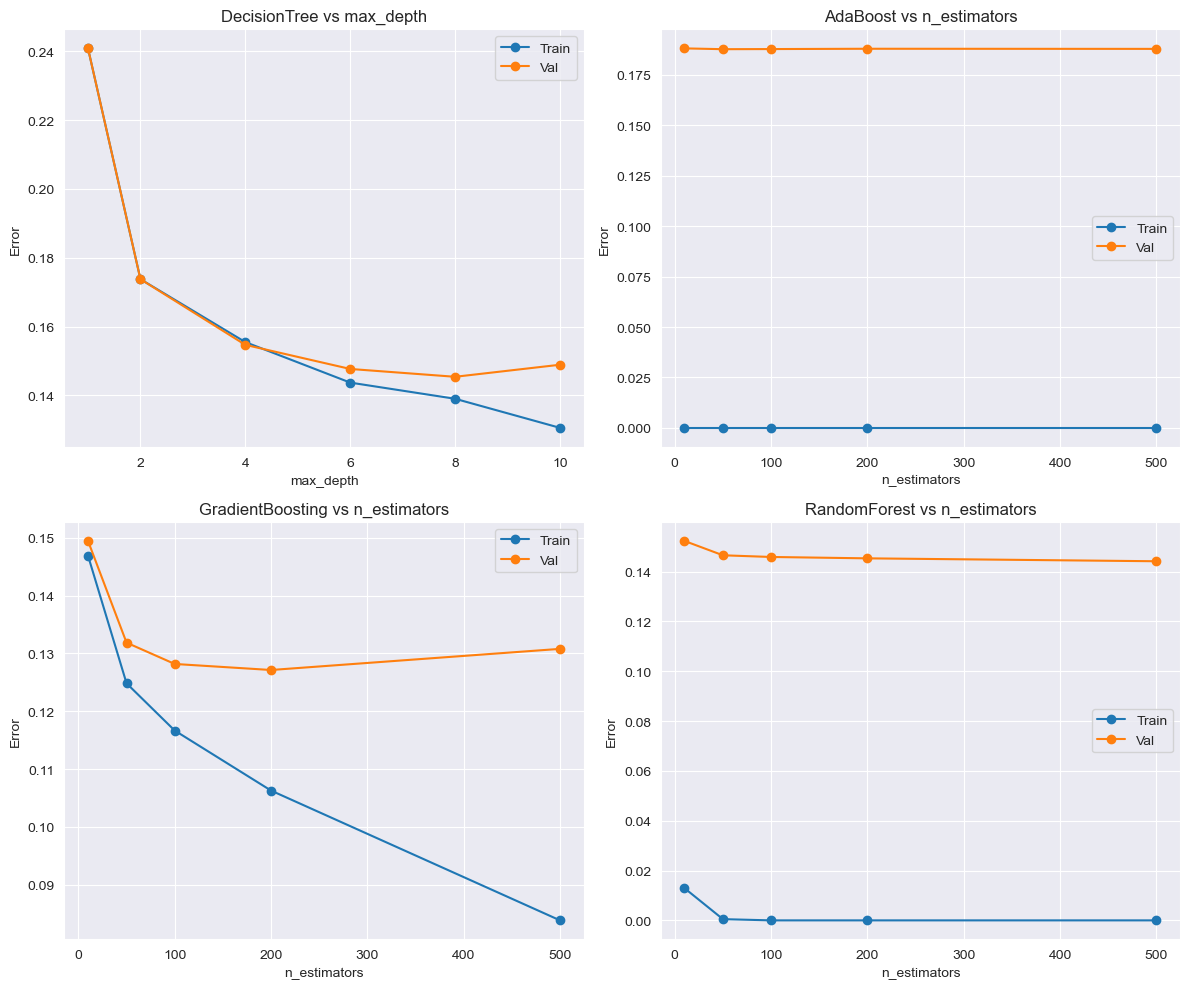

In [67]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

axes[0].plot(dt_depths[:-1], dt_tr[:-1], '-o', label="Train")
axes[0].plot(dt_depths[:-1], dt_val[:-1], '-o', label="Val")
axes[0].set_title("DecisionTree vs max_depth")
axes[0].set_xlabel("max_depth"); axes[0].set_ylabel("Error")
axes[0].legend()

axes[1].plot(ab_estimators, ab_tr, '-o', label="Train")
axes[1].plot(ab_estimators, ab_val, '-o', label="Val")
axes[1].set_title("AdaBoost vs n_estimators")
axes[1].set_xlabel("n_estimators"); axes[1].set_ylabel("Error")
axes[1].legend()

axes[2].plot(gb_estimators, gb_tr, '-o', label="Train")
axes[2].plot(gb_estimators, gb_val, '-o', label="Val")
axes[2].set_title("GradientBoosting vs n_estimators")
axes[2].set_xlabel("n_estimators"); axes[2].set_ylabel("Error")
axes[2].legend()

axes[3].plot(rf_estimators, rf_tr, '-o', label="Train")
axes[3].plot(rf_estimators, rf_val, '-o', label="Val")
axes[3].set_title("RandomForest vs n_estimators")
axes[3].set_xlabel("n_estimators"); axes[3].set_ylabel("Error")
axes[3].legend()

plt.tight_layout()
plt.show()

In [10]:
# Fine tune using grid search
# Define pipelines
pipes = {
    "DecisionTree": Pipeline([
        ("pre", tree_preprocessor),
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("pre", tree_preprocessor),
        ("clf", AdaBoostClassifier(
            estimator=DecisionTreeClassifier(random_state=42),
            algorithm='SAMME',
            random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ("pre", tree_preprocessor),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("pre", tree_preprocessor),
        ("clf", RandomForestClassifier(random_state=42))
    ]),
}

# Set up parameter grids
param_grids = {
    "DecisionTree": {
        "clf__max_depth": [3, 5, 10, 20, None],
        "clf__min_samples_leaf": [1, 5, 10],
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 200, 500],
        "clf__learning_rate": [0.1, 1.0],
        "clf__estimator__max_depth": [1],
    },
    "GradientBoosting": {
        "clf__n_estimators": [100, 200, 500],
        "clf__learning_rate": [0.01, 0.1, 0.5],
        "clf__max_depth": [3, 5],
    },
    "RandomForest": {
        "clf__n_estimators": [100, 200, 500],
        "clf__max_depth": [None, 10, 5],
        "clf__max_features": ["sqrt", 0.5, 1.0],
    },
}

results = {}

# Run grid-search for each estimator
for name, pipe in pipes.items():
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        refit=True
    )
    t0 = time.time()
    grid.fit(X_train, y_train)
    tune_time = time.time() - t0

    best_model = grid.best_estimator_
    test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)

    results[name] = {
        "best_params": grid.best_params_,
        "tune_time_sec": round(tune_time, 1),
        "test_accuracy": round(test_acc, 3)
    }

# Display comparison
for name, info in results.items():
    print(f"{name:15s}  Acc = {info['test_accuracy']}  Time = {info['tune_time_sec']}s")
    print("  Params:", info["best_params"])

DecisionTree     Acc = 0.854  Time = 4.8s
  Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 10}
AdaBoost         Acc = 0.86  Time = 56.4s
  Params: {'clf__estimator__max_depth': 1, 'clf__learning_rate': 1.0, 'clf__n_estimators': 500}
GradientBoosting  Acc = 0.873  Time = 218.0s
  Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}
RandomForest     Acc = 0.861  Time = 250.1s
  Params: {'clf__max_depth': 10, 'clf__max_features': 1.0, 'clf__n_estimators': 100}


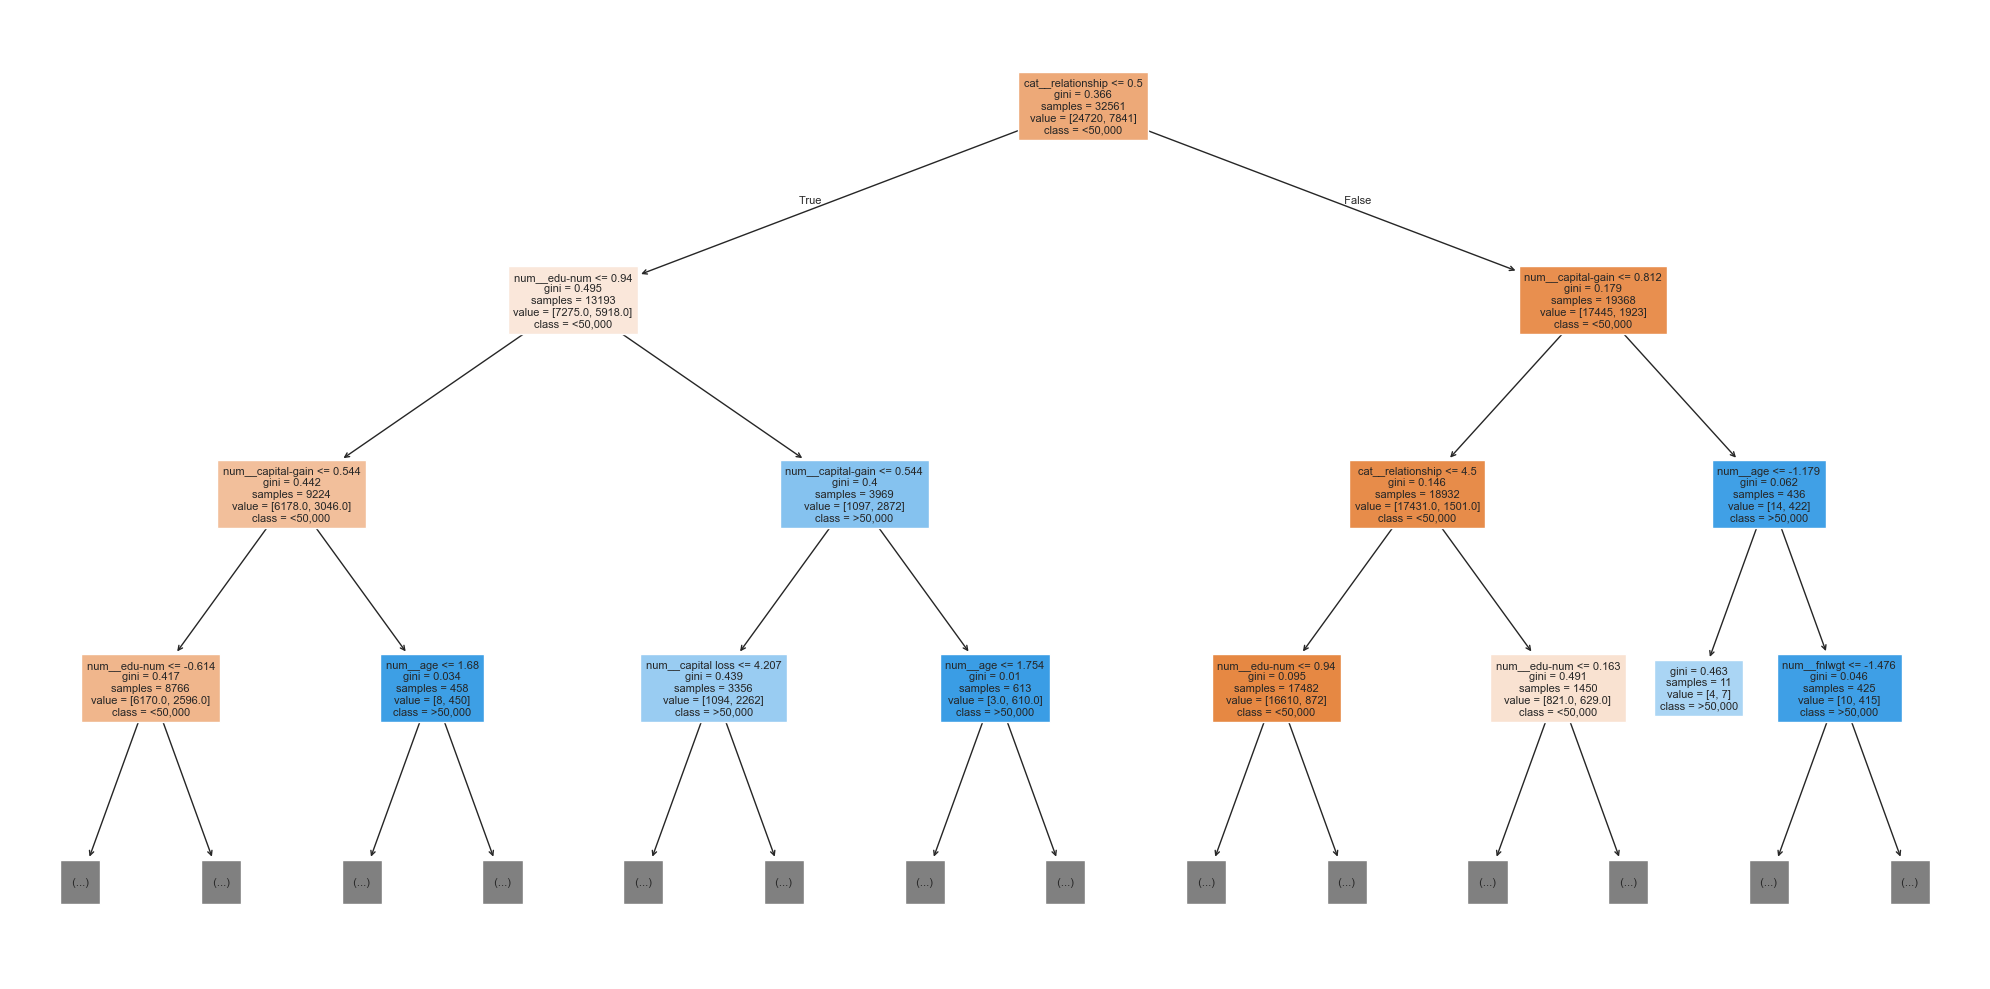

In [11]:
# Interpret and plot the feature importance
# Fit a DecisionTree pipeline and plot the tree
dt_pipe = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('clf', DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=10,
        random_state=42))
])
dt_pipe.fit(X_train, y_train)
dt_clf = dt_pipe.named_steps['clf']
feature_names = dt_pipe.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(
    dt_clf,
    feature_names=feature_names,
    class_names=dt_clf.classes_,
    filled=True,
    max_depth=3,
    fontsize=8
)
plt.tight_layout()
plt.show()

# Fit all tree‐based models
models = {
    'DecisionTree': dt_pipe,
    'AdaBoost': Pipeline([
        ('preprocessor', tree_preprocessor),
        ('clf', AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
            n_estimators=500,
            learning_rate=0.1,
            algorithm='SAMME',
            random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', tree_preprocessor),
        ('clf', GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.7,
            random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', tree_preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            max_features=1.0,
            random_state=42))
    ]),
}
for pipe in models.values():
    pipe.fit(X_train, y_train)

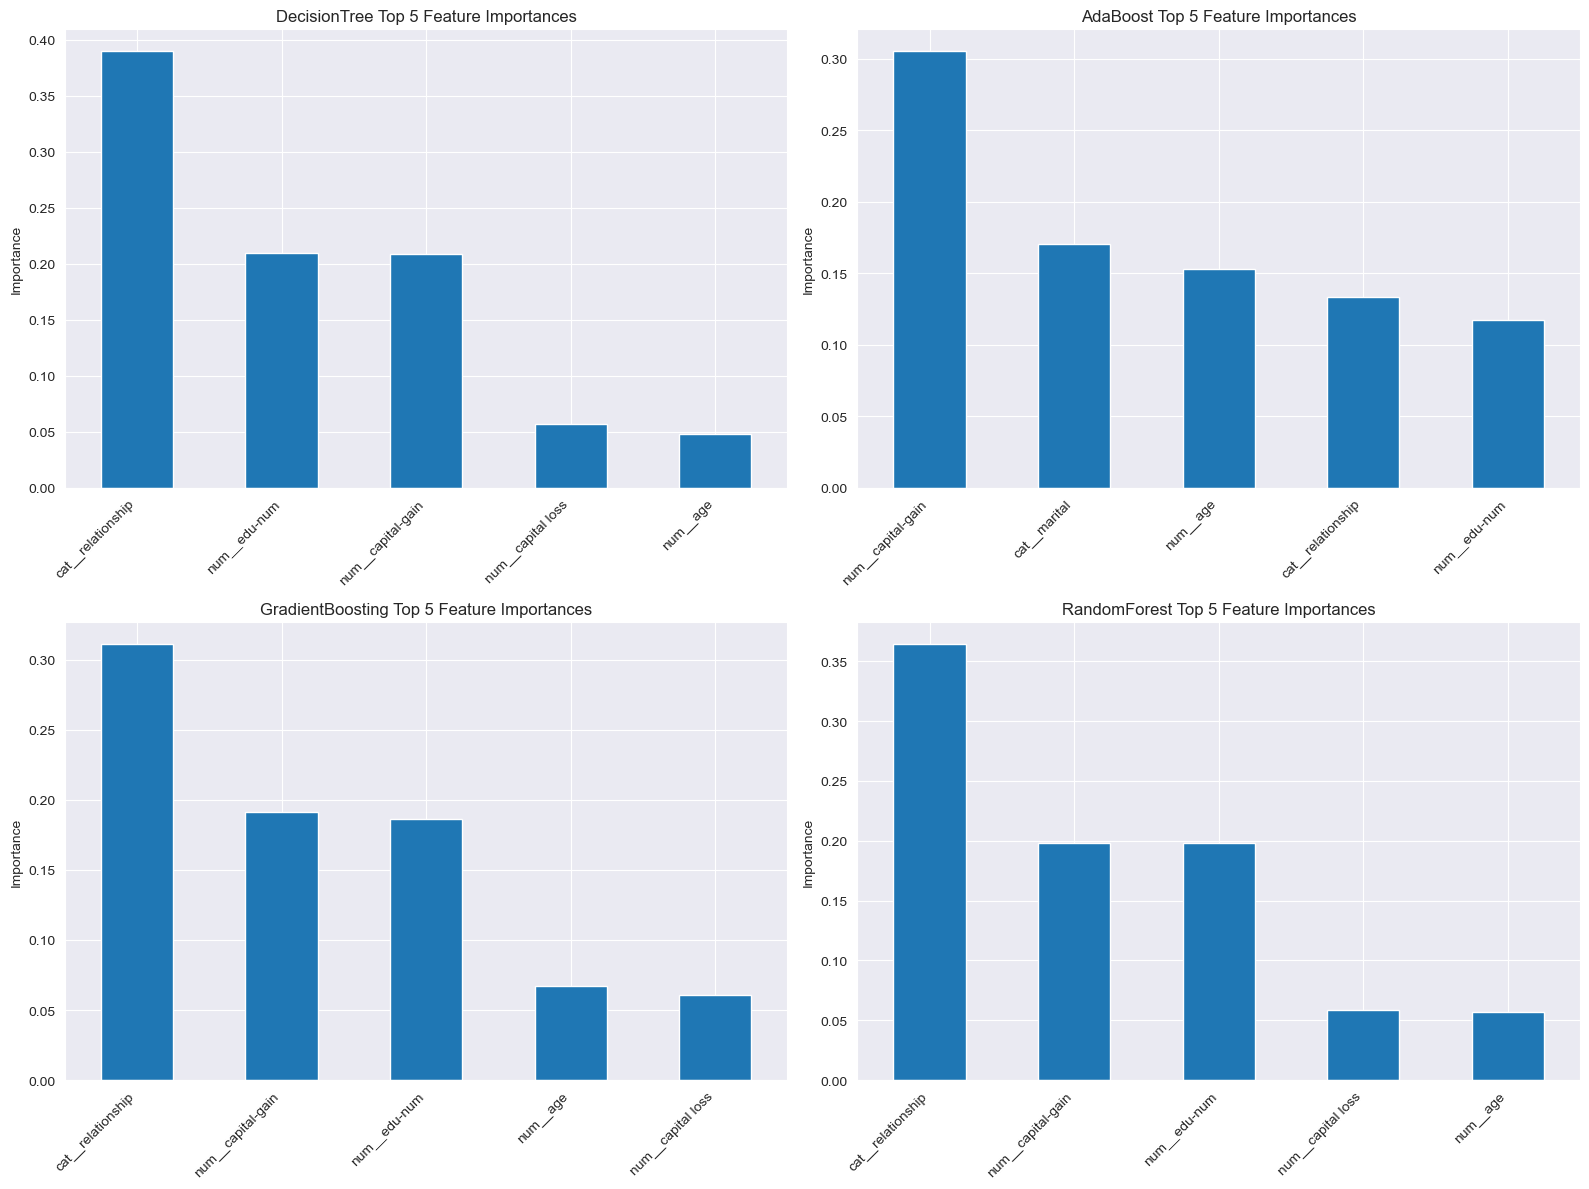

In [15]:
# Extract and plot feature importance in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (name, pipe) in enumerate(models.items()):
    clf = pipe.named_steps['clf']
    importances = clf.feature_importances_
    fnames = pipe.named_steps['preprocessor'].get_feature_names_out()
    imp_series = pd.Series(importances, index=fnames).sort_values(ascending=False).head(5)
    
    imp_series.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{name} Top 5 Feature Importances")
    axes[i].set_ylabel("Importance")
    axes[i].set_xticklabels(imp_series.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [90]:
# Feedforward Neural Network (MLP)
# Define hyperparameter grid
seeds        = [0, 42, 100]
activations  = ['relu', 'tanh']
optimizers   = [('adam', {}), ('sgd', {'learning_rate_init': 0.01})]
layer_sizes  = [(32,), (64,), (32, 16), (64, 32)]
results = []

for random_state in seeds:
    for activation in activations:
        for solver, extra_params in optimizers:
            for hidden in layer_sizes:
                params = {
                    'hidden_layer_sizes': hidden,
                    'activation': activation,
                    'solver': solver,
                    'random_state': random_state,
                    **extra_params
                }
                pipe = Pipeline([
                    ('pre', nn_preprocessor),
                    ('clf', MLPClassifier(max_iter=200, **params))
                ])
                cv_res = cross_validate(
                    pipe,
                    X_train, y_train,
                    cv=3,
                    return_train_score=True,
                    scoring='accuracy',
                    n_jobs=-1
                )
                elapsed = time.time() - t0
                results.append({
                    **params,
                    'train_error': 1 - cv_res['train_score'].mean(),
                    'val_error': 1 - cv_res['test_score'].mean(),
                    'time_sec': elapsed,
                    'hidden_str': str(hidden),
                })

df = pd.DataFrame(results)

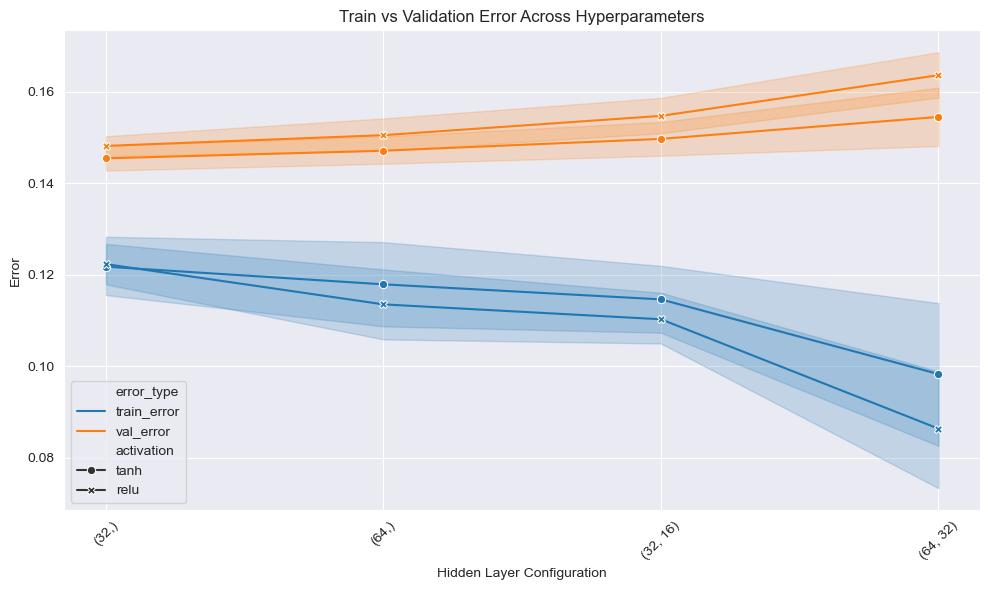

In [92]:
# Melt and plot
df_long = df.melt(
    id_vars=['hidden_str','activation','solver'],
    value_vars=['train_error','val_error'],
    var_name='error_type',
    value_name='error'
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_long,
    x='hidden_str',
    y='error',
    hue='error_type',
    style='activation',
    markers=True,
    dashes=False
)
plt.xlabel('Hidden Layer Configuration')
plt.ylabel('Error')
plt.title('Train vs Validation Error Across Hyperparameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [93]:
# Summarize results and sort ascending by validation error in table
df = df.sort_values('val_error').reset_index(drop=True)
print(df.head(20))

   hidden_layer_sizes activation solver  random_state  train_error  val_error  \
0               (32,)       tanh    sgd             0     0.129357   0.141089   
1               (32,)       tanh    sgd            42     0.131968   0.142256   
2               (32,)       tanh    sgd           100     0.129772   0.142502   
3               (64,)       tanh    sgd           100     0.130263   0.142839   
4               (64,)       tanh    sgd            42     0.131998   0.143331   
5               (64,)       tanh    sgd             0     0.130954   0.143914   
6            (32, 16)       tanh    sgd           100     0.125180   0.144160   
7               (32,)       relu    sgd           100     0.127023   0.144191   
8            (32, 16)       tanh    sgd            42     0.124965   0.144559   
9            (64, 32)       tanh    sgd           100     0.120528   0.144713   
10              (64,)       relu    sgd             0     0.125226   0.145327   
11              (32,)       

In [100]:
# Proper finetuning
mlp_pipe = Pipeline([
    ('pre', nn_preprocessor),
    ('clf', MLPClassifier(max_iter=400, early_stopping=True,  # allow it to stop as soon as validation stops improving
                          validation_fraction=0.1, n_iter_no_change=10))
])

# Define more hyperparameter space to explore
param_dist = {
    'clf__hidden_layer_sizes': [(32,), (64,), (32,16), (64,32), (128,64)],
    'clf__activation':         ['tanh','relu'],
    'clf__solver':             ['sgd','adam'],
    'clf__learning_rate_init': [1e-4, 1e-3, 1e-2],
    'clf__alpha':              [1e-5, 1e-4, 1e-3],        # L2 penalty
    'clf__batch_size':         ['auto', 64, 128],
}

# 50 random draws from the above space, 3‐fold CV
rnd_search = RandomizedSearchCV(
    mlp_pipe,
    param_dist,
    n_iter=100,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)

# time the tuning
t0 = time.time()
rnd_search.fit(X_train, y_train)
tune_time = time.time() - t0

best_mlp = rnd_search.best_estimator_
best_params = rnd_search.best_params_

print("Tuning time (sec):", round(tune_time,1))
print("Best hyperparameters:")
for k,v in best_params.items():
    print(f"  {k} = {v}")

test_acc_mlp = best_mlp.score(X_test, y_test)
print("Test accuracy of best MLP:", round(test_acc_mlp,4))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Tuning time (sec): 556.9
Best hyperparameters:
  clf__solver = adam
  clf__learning_rate_init = 0.001
  clf__hidden_layer_sizes = (128, 64)
  clf__batch_size = 128
  clf__alpha = 0.0001
  clf__activation = tanh
Test accuracy of best MLP: 0.8604
